In [5]:
# 1. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score,
    precision_score, recall_score, f1_score, roc_auc_score
)

# 2. Settings
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# 3. Load processed data
df = pd.read_csv("../data/processed_attrition.csv")

# 4. Quick check
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,0.446350,1,0.590048,0.742527,1.401512,-1.010909,-0.891688,-0.937414,-0.660531,-1.224745,...,-0.426230,-1.584178,-0.932014,-0.421642,-2.171982,-2.493820,-0.164613,-0.063296,-0.679146,0.245834
1,1.322365,0,-0.913194,-1.297775,-0.493817,-0.147150,-1.868426,-0.937414,0.254625,0.816497,...,2.346151,1.191438,0.241988,-0.164511,0.155707,0.338096,0.488508,0.764998,-0.368715,0.806541
2,0.008343,1,0.590048,1.414363,-0.493817,-0.887515,-0.891688,1.316673,1.169781,0.816497,...,-0.426230,-0.658973,-0.932014,-0.550208,0.155707,0.338096,-1.144294,-1.167687,-0.679146,-1.155935
3,-0.429664,0,-0.913194,1.461466,-0.493817,-0.764121,1.061787,-0.937414,1.169781,-1.224745,...,-0.426230,0.266233,-0.932014,-0.421642,0.155707,0.338096,0.161947,0.764998,0.252146,-1.155935
4,-1.086676,0,0.590048,-0.524295,-0.493817,-0.887515,-1.868426,0.565311,-1.575686,0.816497,...,-0.426230,1.191438,0.241988,-0.678774,0.155707,0.338096,-0.817734,-0.615492,-0.058285,-0.595227


## Exploring Tree-Based Models through Feature Engineering

Building on our baseline logistic regression, we now explore tree-based models such as **Random Forests**, which are better equipped to capture complex, nonlinear relationships and feature interactions.

The correlation matrix created in our previous notebook (`modeling_attrition`) highlighted key insights:

- **OverTime** showed a **positive correlation with Attrition** (~ **r = 0.25**), suggesting overworked employees are more likely to leave.
- **JobSatisfaction** and **EnvironmentSatisfaction** were both **negatively correlated** (r ≈ -0.15 to -0.2), indicating that lower satisfaction levels are associated with higher attrition.
- Most numeric features had weak linear relationships with attrition (|r| < 0.10), highlighting the **limitation of purely linear models**.

These results support our intuition that employee attrition is shaped by **complex, multifactorial** conditions—workload, support, pay, satisfaction, and role-specific context all interact. Tree-based models excel in capturing such layered logic by allowing different feature combinations to guide prediction paths.

This notebook revisits feature engineering with those interactions in mind, and evaluates a tree-based model's ability to improve predictive performance and interpretability.

## Addressing Class Imbalance with Class Weighting

In our baseline model, we observed a recall of just 40% for employees who actually left the company (the minority class). This means that the model correctly identified **only 4 out of every 10 employees who ended up leaving, potentially leaving HR teams unaware of the majority of at-risk employees. In a real-world context, this could result in missed opportunities for proactive intervention or support.**

This performance issue is largely due to class imbalance, where the dataset contains many more examples of employees who stayed than those who left. As a result, the model becomes biased toward predicting that employees will stay, simply because that’s what it sees most often during training.

To address this, we will explore two popular techniques for improving the model’s ability to detect employees at risk of attrition:
- `class_weight='balanced'`: Adjusts the model to give more importance to underrepresented examples (i.e., employees who left).
- SMOTE (Synthetic Minority Over-sampling Technique): Creates synthetic examples of the minority class to help the model learn its patterns better.

These adjustments can help ensure that our predictive model prioritizes not just overall accuracy, but also **correctly identifies employees most in need of support or retention efforts.**

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE

# Define features and target variable
X = df.drop(columns="Attrition")
y = df["Attrition"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=5
)

# OPTION 1: Decision tree with weighted classes
tree_weighted = DecisionTreeClassifier(class_weight="balanced", random_state=5)
tree_weighted.fit(X_train, y_train)
y_pred_weighted = tree_weighted.predict(X_test)

# OPTION 2: Deicision tree with SMOTE
smote = SMOTE(random_state=5)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

tree_smote = DecisionTreeClassifier(random_state=5)
tree_smote.fit(X_train_sm, y_train_sm)
y_pred_smote = tree_smote.predict(X_test)

# Print results
print("== Decision Tree with class_weight='balanced' ==")
print(classification_report(y_test, y_pred_weighted))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_weighted))
print("ROC AUC Score:", roc_auc_score(y_test, tree_weighted.predict_proba(X_test)[:, 1]))

print("\n== Decision Tree with SMOTE ==")
print(classification_report(y_test, y_pred_smote))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_smote))
print("ROC AUC Score:", roc_auc_score(y_test, tree_smote.predict_proba(X_test)[:, 1]))

== Decision Tree with class_weight='balanced' ==
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       247
           1       0.24      0.26      0.25        47

    accuracy                           0.75       294
   macro avg       0.55      0.55      0.55       294
weighted avg       0.76      0.75      0.75       294

Confusion Matrix:
 [[209  38]
 [ 35  12]]
ROC AUC Score: 0.5507364975450081

== Decision Tree with SMOTE ==
              precision    recall  f1-score   support

           0       0.89      0.83      0.86       247
           1       0.34      0.47      0.40        47

    accuracy                           0.77       294
   macro avg       0.62      0.65      0.63       294
weighted avg       0.80      0.77      0.79       294

Confusion Matrix:
 [[205  42]
 [ 25  22]]
ROC AUC Score: 0.6490223102765096


### Comparing the Models
In the context of employee attrition, we are particularly interested in correctly identifying those who are likely to leave (Attrition = 1), since early intervention can help reduce costly turnover. However, in our baseline model, only 40% of employees who left were correctly identified, a signal that the model struggles with the minority class.

This is known as class imbalance, where one category (employees who stay) dominates the dataset. In our case, about 84% of employees stayed, and only 16% left. This imbalance skews the model toward predicting "stay" more often, which inflates accuracy but hurts recall and precision for attrition, the group HR teams care most about.

### Method 1: Class Weighting
We trained a Decision Tree using `class_weight='balanced'`, which adjusts for imbalance by penalizing mistakes on minority class examples more heavily.

- **Recall for attrition (class 1)**: **0.26**
- **Precision for attrition**: **0.24**
- **ROC AUC**: **0.55**
- Performance remained poor... the model still missed most of the actual attrition cases (35 out of 47), showing this method wasn’t very effective here.

### Method 2: SMOTE Oversampling
We then applied SMOTE (Synthetic Minority Oversampling Technique), which creates synthetic data points for the minority class to help the model learn patterns more effectively.

- **Recall for attrition**: **0.47**
- **Precision for attrition**: **0.34**
- **ROC AUC**: **0.65**
- While far from perfect, this is a noticeable improvement in both recall and ROC AUC. The model is catching more true attrition cases (22 out of 47), making it more actionable in an HR setting. Given it’s stronger performance, we will use SMOTE going forward to handle class imbalance in training data.

## Random Forest Classifier with SMOTE

In [8]:
# Split
X = df.drop(columns='Attrition')
y = df['Attrition']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=5
)

# SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_smote, y_train_smote)

# Predict and evaluation
y_pred_rf = rf_model.predict(X_test)
print("== Random Forest with SMOTE ==")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("ROC AUC Score:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))

== Random Forest with SMOTE ==
              precision    recall  f1-score   support

           0       0.86      0.98      0.91       247
           1       0.57      0.17      0.26        47

    accuracy                           0.85       294
   macro avg       0.72      0.57      0.59       294
weighted avg       0.81      0.85      0.81       294

Confusion Matrix:
 [[241   6]
 [ 39   8]]
ROC AUC Score: 0.7710827806012577


## RF Evaluation Summary

The Random Forest classifier trained on SMOTE-balanced data produced high accuracy (85%) and strong recall for employees who stayed with the company (class 0). However, it still struggled to detect employees who left (class 1), correctly identifying only 8 out of 47.

- **Class 0 (Stayed):** Precision 0.86 | Recall 0.98 | F1 Score 0.91
- **Class 1 (Left):** Precision 0.57 | Recall 0.17 | F1 Score 0.26
- **ROC AUC Score:** 0.77 — indicates moderate discriminative ability

While the model shows solid general performance, it is still **missing most of the employees who left**, which is critical for proactive HR intervention. These misclassifications (39 false negatives) could translate to missed opportunities to support and retain talent.

## Feature Importance and Interpretability

C:\Users\mturner\AppData\Local\Temp\ipykernel_21652\3879857602.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')


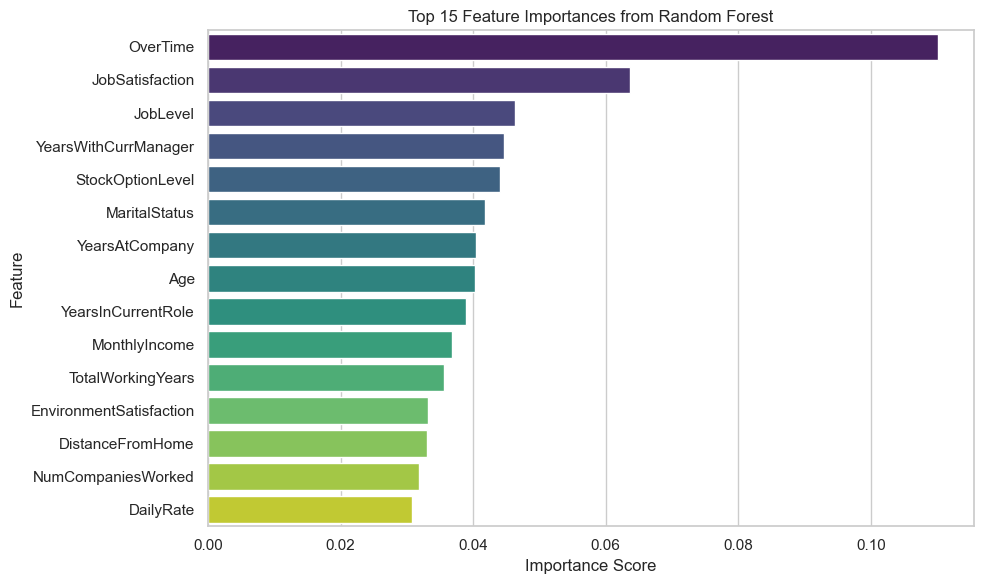

In [11]:
# Assuming `rf_smote` is your trained model and `X_train_res` is your training data after SMOTE
feature_importances = pd.DataFrame({
    'Feature': X_train_smote.columns,
    'Importance': rf_model.feature_importances_
})

# Sort and plot
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances.head(15), palette='viridis')
plt.title('Top 15 Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Feature Importance Analysis: Random Forest 

Understanding which factors most influence employee attrition helps HR leaders prioritize areas for proactive intervention. The following ranks and discusses the top 15 features by importance in the Random Forest model trained with SMOTE to address class imbalance.

### Top Predictive Features:
1. **OverTime** – With the highest importance score (0.11), frequent overtime stands out as the strongest predictor of employee attrition. This aligns with research suggesting that excessive work demands can contribute to burnout and resignation.
2. **Job Satisfaction** and **Job Level** – These variables suggest that an employee’s day-to-day fulfillment and their position in the company hierarchy significantly influence their likelihood of staying.
3. **Years with Current Manager** – A sign of managerial stability or instability. Longer tenure with the same manager may reduce attrition if the relationship is supportive.
4. **Stock Option Level** and **Marital Status** – Compensation-related benefits and personal circumstances seem to factor into an employee’s decision to remain with or leave the company.
5. **Tenure-related variables** – Including **YearsAtCompany**, **YearsInCurrentRole**, and **TotalWorkingYears**, all appear highly influential. These reflect institutional knowledge and career progression.
6. **Age** – Although standardized, age still played a significant role, potentially as a proxy for experience or life stage.
7. **Environment Satisfaction** and **Distance From Home** – Highlighting how workplace conditions and commuting burden can influence employee decisions.
8. **Num Companies Worked** – A history of job-switching may indicate a higher risk of future attrition.

### Key Takeaway:
**The model emphasizes a mix of job-specific, personal, and managerial factors. Notably, work-life balance, satisfaction, and compensation stand out as critical levers.** This insight can guide HR professionals in designing targeted retention strategies—such as optimizing workloads, improving manager-employee relationships, and offering more tailored benefits.



## Testing Gradient Boosted Models

In [13]:
from xgboost import XGBClassifier

# Initialize model
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=5,
    eval_metric='logloss'
)

# Fit model
xgb_model.fit(X_train_smote, y_train_smote)

# Predict on original test set (not SMOTE)
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Print model evaluation results
print("== XGBoost Classifier ==")
print(classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba_xgb))

== XGBoost Classifier ==
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       247
           1       0.50      0.30      0.37        47

    accuracy                           0.84       294
   macro avg       0.69      0.62      0.64       294
weighted avg       0.82      0.84      0.82       294

Confusion Matrix:
 [[233  14]
 [ 33  14]]
ROC AUC Score: 0.7637178051511759


After applying SMOTE to address class imbalance, we tested an XGBoost classifier to improve our model’s ability to detect employee attrition. While the model achieved an accuracy of 84% and a ROC AUC score of 0.76, **we still observed low recall for the minority class (employees who left):**

- Class 0 (Stayed): Precision = 0.88, Recall = 0.94, F1 = 0.91

- Class 1 (Left): Precision = 0.50, Recall = 0.30, F1 = 0.37

While the model correctly identifies most employees who stayed, it only catches 30% of those who actually left. In a real-world HR setting, this level of recall is too low to be actionable. If the model fails to flag potential leavers, HR cannot intervene early, which is typically the goal of attrition prediction. Given that our Random Forest model performed slightly better in terms of balance and recall (though still not ideal), and that tree-based models generally benefit significantly from hyperparameter tuning, we will now perform a Grid Search to fine-tune our Random Forest model in the ```tuned_thresholds``` notebook.